# Digital Pathology Image Analysis:
## EulerianKnight Breast Histopathology Images

Group 16

Luke Chesley
lc3368@drexel.edu

Lauren Miller
lem324@drexel.edu

## Background


Digital pathology (DP) is the process by which histology
slides are digitized to produce high-resolution images.
DP is becoming increasingly common due to the growing
availability of whole slide digital scanners.(1) Deep learnng is well suited for image analysis in digital pathology (DP). Analysis tasks in the area of DP include detection and counting, segmentation, and tissue classification. A number of image analysis tasks in DP involve some sort of quantification (e.g., cell or mitosis counting) or tissue grading (classification).

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is an extremely common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task. Automated methods can be used to save time and reduce error in these tasks. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. A common pre-processing step for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: u_xX_yY_classC.png — > example 10253_idx5_x1351_y1101_class0.png . Where u is the patient ID (10253_idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

## Description of Dataset

This dataset contains 277000 images with no missing values (as seen below). In this dataset the images are stored as pil image objects, with 3 color channels (red, blue, green). the size is 50x50 pixels. This format is particularly useful for image transformations, which can be done using Pillow itself or PyTorch's torchvision transforms, as they can directly operate on PIL image objects. (2)

The labels of the data indicate if the sample image contains cancer or not. 0 represents a negative sample, 1 represents a positive sample.(2)

The data is presented in the following structure:

|-- train
      |-- class(0 and 1)

  |-- valid
      |-- class(0 and 1)

  |-- test
      |-- class(0 and 1)


### Importing Data


In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image

from PIL import Image
import pandas as pd


from collections import Counter

In [5]:
#importing data through api
dataset_name = "EulerianKnight/breast-histopathology-images-train-test-valid-split"
dataset = load_dataset(dataset_name)

Using the latest cached version of the dataset since EulerianKnight/breast-histopathology-images-train-test-valid-split couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/EulerianKnight___breast-histopathology-images-train-test-valid-split/default/0.0.0/6efb6831d01845dcfb2b06214986c882d453444e (last modified on Wed Apr 17 13:02:57 2024).


In [6]:
#what does the dataset look like
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 277000
    })
})

In [7]:
num_dicts = len(dataset['train'])
print("Number of image/label dictionaries in the data:", num_dicts)

Number of image/label dictionaries in the data: 277000


In [8]:
#check for any missing values
train_dataset = dataset['train']

num_rows = train_dataset.num_rows
num_missing = num_rows - len(train_dataset)

if num_missing > 0:
  print('Missing data found in the train dataset')
  print('Number of missing rows:', num_missing)
else:
  print('No missing data found in the train dataset')

No missing data found in the train dataset


## Exploratory Data Analysis of Data

### Initial Data

In [9]:
#image and label stored in a dictionary format
dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50>,
 'label': 0}

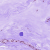

In [10]:
#image from dataset
image = dataset['train'][0]['image']
image

### Taking a Random Sample of Data from the Dataset to Continue Exploratory Data Analysis

In [46]:
train_data = dataset['train']

In [47]:
#get a random sample of the dataset to work with
import random

randomized_sample = train_data.shuffle()

# Sample size
sample_size = 1000

# Take a sample of the specified size
randomized_sample = randomized_sample[:sample_size]

In [57]:
#confirm data type
print(type(randomized_sample))

<class 'dict'>


In [58]:
#extract image data and labels from train dataset
images = randomized_sample['image']
labels = randomized_sample['label']

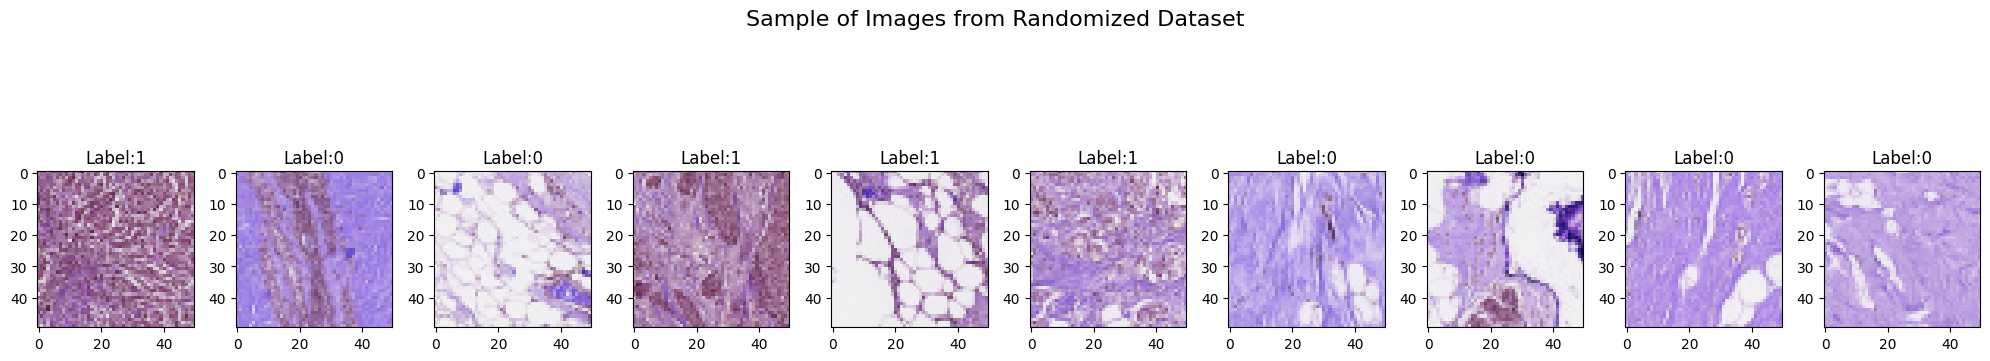

In [90]:
#sample of images from randomized dataset
title = 'Sample of Images from Randomized Dataset'
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20,5))
for i in range(num_samples):
  axes[i].imshow(images[i])
  axes[i].set_title('Label:' + str(labels[i]))

plt.tight_layout()
plt.suptitle(title, fontsize=16)
plt.show()

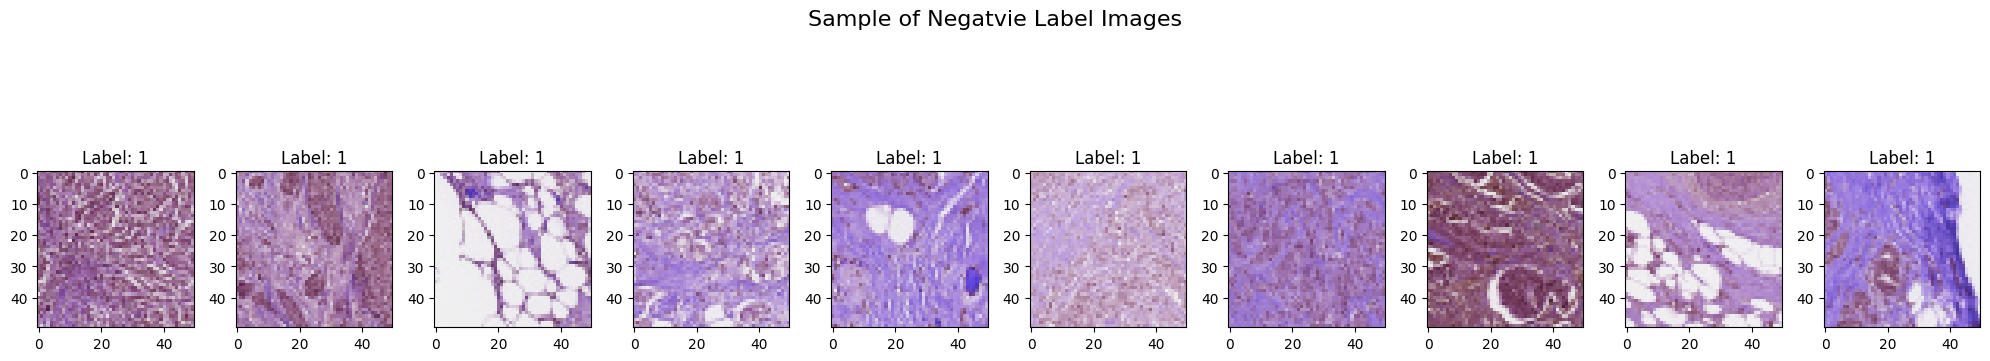

In [89]:
# Filter images and labels to include only label 1
title = 'Sample of Negatvie Label Images'

label_1_images = [img for img, label in zip(images, labels) if label == 1]
label_1_labels = [label for label in labels if label == 1]

num_samples = 10

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
for i in range(num_samples):
    axes[i].imshow(label_1_images[i])
    axes[i].set_title('Label: 1')

plt.tight_layout()
plt.suptitle(title, fontsize=16)
plt.show()

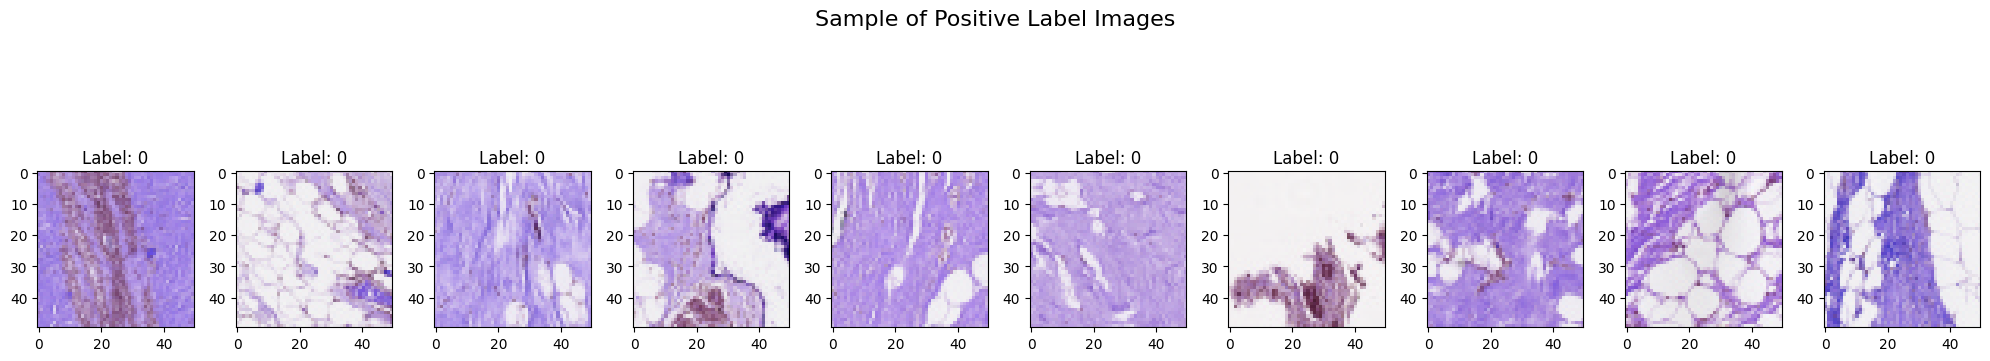

In [91]:
# Filter images and labels to include only label 1
title = 'Sample of Positive Label Images'
label_0_images = [img for img, label in zip(images, labels) if label == 0]
label_0_labels = [label for label in labels if label == 0]

num_samples = 10

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
for i in range(num_samples):
    axes[i].imshow(label_0_images[i])
    axes[i].set_title('Label: 0')


plt.tight_layout()
plt.suptitle(title, fontsize=16)
plt.show()

### Distribution of Negatvie and Positive Classes within the Randomized Data from Dataset

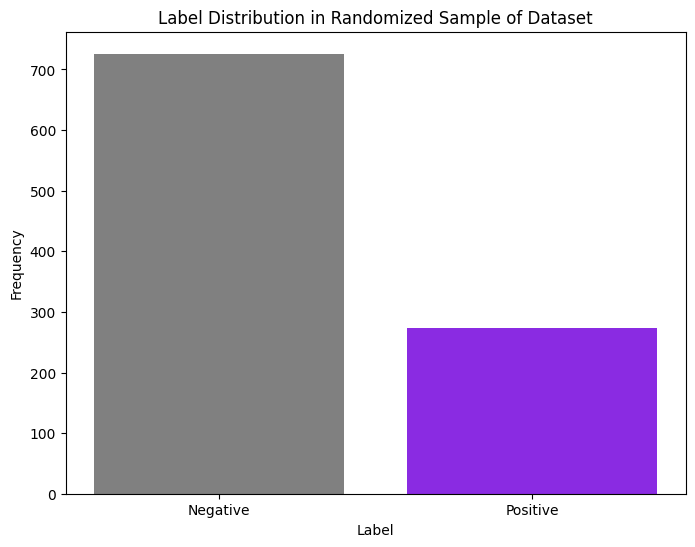

In [81]:
import matplotlib.pyplot as plt
purple = '#8A2BE2'
grey = '#808080'

#count the occurrences of each label 0 and 1
label_counts = {}
for label in labels:
    label_counts[label] = label_counts.get(label, 0) + 1

plt.figure(figsize=(8, 6))
colors = [grey if label == 0 else purple for label in label_counts.keys()]
plt.bar(label_counts.keys(), label_counts.values(), color=colors)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution in Randomized Sample of Dataset')
plt.xticks([0,1], ['Negative', 'Positive'])
plt.show()

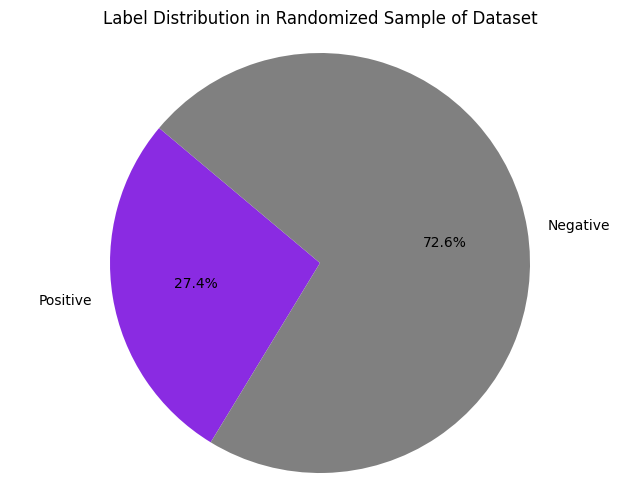

In [83]:
#count the occurrences of each label 0 and 1
label_counts = {}
for label in labels:
    label_counts[label] = label_counts.get(label, 0) + 1

colors = [purple,grey]
plt.figure(figsize=(8, 6))
plt.pie(label_counts.values(), labels=['Positive', 'Negative'], colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Label Distribution in Randomized Sample of Dataset')
plt.axis('equal')

plt.show()

## Further Analysis of Data
Further potential analysis and processing of this data includes the following:
1. Converting these PIL images to tensors for ML
2. Exploring correlations between images features (colors, textures, etc)
3. Image pixel distribution
4. Dimensionality reduction
5. Data augmentation exploration

### Algorithms Intended to be Applied

This dataset involves classification tasks. The algorithms we intend to apply to the dataset are as follows:
1. Convolutional Neural Networks (CNNs)

  CNNs are the most common choice algorithm for image classification tasks. This is due to thier ability to automatically learn hierarchical features from images.

2. Random Forests and Decision Trees

  These algorithms can be applied with features extract from images.
  
3. k-Nearest Neighbors(k-NN)


  This algorithm can be applied using feature representaiton of images.


### Project Objectives

Our objective is to build a classification model that can accurately detect cancerous histological slide images. This machine learning project utilizing breast histopathology images aims to contribute to improving the accuracy, efficiency, and reproducibility of breast cancer diagnosis, prognosis, and treatment planning, ultimately leading to better patient outcomes. 

## References

(1) Janowczyk, A., & Madabhushi, A. (2016). Deep learning for digital pathology image analysis: A comprehensive tutorial with selected use cases. Journal of pathology informatics, 7, 29. https://doi.org/10.4103/2153-3539.186902

(2) EulerianKnight. (n.d.). Breast Histopathology Images (Train, Test, Valid Split) [Dataset]. Hugging Face Datasets. Retrieved from https://huggingface.co/datasets/EulerianKnight/breast-histopathology-images-train-test-valid-split